# Abt-Buy Dataset

O **Abt-Buy** é um conjunto de dados amplamente utilizado em experimentos de *Record Linkage*, *Entity Matching* e *Data Deduplication*.  
Ele foi introduzido no artigo *Deep Learning for Entity Matching* (Mudgal et al., SIGMOD 2018) e faz parte do benchmark oficial do **DeepMatcher**.

O dataset contém pares de produtos provenientes de duas lojas online — **Abt.com** e **Buy.com** — e é frequentemente usado para avaliar modelos supervisionados de correspondência de entidades baseados em redes neurais.

---

## Estrutura dos Arquivos

| Arquivo | Descrição |
|----------|-----------|
| `tableA.csv` | Produtos da loja **Abt.com** |
| `tableB.csv` | Produtos da loja **Buy.com** |
| `train.csv` | Conjunto de **treinamento**, com pares rotulados (match / non-match) |
| `valid.csv` | Conjunto de **validação** |
| `test.csv` | Conjunto de **teste** |

---

## Estrutura das Tabelas

### Arquivo `tableA.csv` (Abt)

| Coluna | Descrição |
|---------|-----------|
| `id` | Identificador único do produto na Abt |
| `name` | Nome do produto |
| `description` | Descrição textual |
| `price` | Preço listado (em USD) |

### Arquivo `tableB.csv` (Buy)

| Coluna | Descrição |
|---------|-----------|
| `id` | Identificador único do produto na Buy |
| `name` | Nome do produto |
| `description` | Descrição textual |
| `price` | Preço listado (em USD) |

---

## Arquivos de Pareamento

Os arquivos `train.csv`, `valid.csv` e `test.csv` possuem o mesmo formato:

| Coluna | Descrição |
|---------|-----------|
| `ltable_id` | Referência ao campo `id` em `tableA.csv` (Abt) |
| `rtable_id` | Referência ao campo `id` em `tableB.csv` (Buy) |
| `label` | 1 = os produtos correspondem (match); 0 = produtos diferentes (non-match) |

---

## Estatísticas Resumidas

| Conjunto | Número de pares | Percentual de positivos (aproximado) | Observações |
|-----------|----------------|---------------------------------------|--------------|
| Treino (`train.csv`) | ~8.000 | ~7% | Base principal para ajuste de modelo |
| Validação (`valid.csv`) | ~1.000 | ~7% | Utilizado para ajuste de hiperparâmetros |
| Teste (`test.csv`) | ~1.000 | ~7% | Utilizado para avaliação final |

Cada tabela (`tableA` e `tableB`) contém aproximadamente **1.000 produtos únicos**.  
Os pares foram gerados por heurísticas de *blocking* (por exemplo, similaridade de marca) para reduzir o número de comparações possíveis.

---

## Exemplo de Registro

| ltable_id | rtable_id | label | name (Abt) | name (Buy) |
|------------|------------|--------|-------------|-------------|
| 730 | 775 | 1 | Canon PowerShot SD1300 12.1MP | Canon SD1300 IS Digital Camera 12.1MP |

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(style='whitegrid')

# Parte 1: Análise Exploratória

In [17]:
import pandas as pd

# Caminho base do dataset
path = "../data/abt_buy/"

# Carregar tabelas e pares rotulados
tableA = pd.read_csv(f"{path}tableA.csv")
tableB = pd.read_csv(f"{path}tableB.csv")
train = pd.read_csv(f"{path}train.csv")
valid = pd.read_csv(f"{path}valid.csv")
test = pd.read_csv(f"{path}test.csv")

# Inspecionar o esquema e algumas amostras
print("Table A (Abt):", tableA.shape)
print("Table B (Buy):", tableB.shape)
print("Train:", train.shape)

print("\nColunas de TableA:", tableA.columns.tolist())
print("Colunas de Train:", train.columns.tolist())

# Exemplo de merge entre pares e tabelas
sample = train.sample(5, random_state=42)
merged = (
    sample.merge(tableA, left_on="ltable_id", right_on="id", suffixes=("", "_A"))
          .merge(tableB, left_on="rtable_id", right_on="id", suffixes=("_A", "_B"))
)
cols = ["ltable_id", "rtable_id", "label", "name_A", "name_B", "price_A", "price_B"]
merged[cols].head()

Table A (Abt): (1081, 4)
Table B (Buy): (1092, 4)
Train: (5743, 3)

Colunas de TableA: ['id', 'name', 'description', 'price']
Colunas de Train: ['ltable_id', 'rtable_id', 'label']


,ltable_id,rtable_id,label,name_A,name_B,price_A,price_B
0,843,821,0,speck seethru orange hard shell case for 13 ' ...,speck products seethru case for apple 13 ' mac...,NaN,NaN
1,544,692,0,panasonic black dvd home theater sound system ...,samsung htz410t home theater system htz410t,289.0,279.00
2,725,687,1,sharp 26 ' black lcd hdtv with built in dvd pl...,sharp lc26dv24u 26 ' tv/dvd combo,NaN,508.72
3,459,464,0,sirius siriusconnect vehicle kit in black scvdoc1,sirius sportster 5 radio with vehicle kit,59.0,131.99
4,515,547,0,toshiba black dvd recorder/vcr combinaton with...,toshiba d-vr610 dvd vcr combo,NaN,NaN


## 1️⃣ Carga dos dados

In [18]:
path = '../data/abt_buy/'  # adjust as needed
tableA = pd.read_csv(f'{path}/tableA.csv')
tableB = pd.read_csv(f'{path}/tableB.csv')
train = pd.read_csv(f'{path}/train.csv')
valid = pd.read_csv(f'{path}/valid.csv')
test = pd.read_csv(f'{path}/test.csv')
tableA.head()

,id,name,description,price
0,0,sony turntable pslx350h,sony turntable pslx350h belt drive system 33-1...,NaN
1,1,bose acoustimass 5 series iii speaker system a...,bose acoustimass 5 series iii speaker system a...,399.0
2,2,sony switcher sbv40s,sony switcher sbv40s eliminates disconnecting ...,49.0
3,3,sony 5 disc cd player cdpce375,sony 5 disc cd player - cdpce375 5 disc change...,NaN
4,4,bose 27028 161 bookshelf pair speakers in whit...,bose 161 bookshelf speakers in white 161wh art...,158.0


## 2️⃣ Inspeção

In [19]:
print('Table A columns:', tableA.columns.tolist())
print('Table B columns:', tableB.columns.tolist())
print('Training pairs:', len(train))
print('Positive ratio:', (train.label.sum() / len(train)) * 100, '%')

Table A columns: ['id', 'name', 'description', 'price']
Table B columns: ['id', 'name', 'description', 'price']
Training pairs: 5743
Positive ratio: 10.726101340762668 %


## 3️⃣ Amostra de pares

In [20]:
sample = train.sample(5, random_state=42)

merged = (
    sample.merge(tableA, left_on='ltable_id', right_on='id', suffixes=('', '_A'))
          .merge(tableB, left_on='rtable_id', right_on='id', suffixes=('_A', '_B'))
)

cols = ['ltable_id', 'rtable_id', 'label', 'name_A', 'name_B', 'price_A', 'price_B']
merged[cols]

,ltable_id,rtable_id,label,name_A,name_B,price_A,price_B
0,843,821,0,speck seethru orange hard shell case for 13 ' ...,speck products seethru case for apple 13 ' mac...,NaN,NaN
1,544,692,0,panasonic black dvd home theater sound system ...,samsung htz410t home theater system htz410t,289.0,279.00
2,725,687,1,sharp 26 ' black lcd hdtv with built in dvd pl...,sharp lc26dv24u 26 ' tv/dvd combo,NaN,508.72
3,459,464,0,sirius siriusconnect vehicle kit in black scvdoc1,sirius sportster 5 radio with vehicle kit,59.0,131.99
4,515,547,0,toshiba black dvd recorder/vcr combinaton with...,toshiba d-vr610 dvd vcr combo,NaN,NaN


##  4️⃣ Similaridade Textual entre Produtos

O código abaixo realiza uma análise exploratória das similaridades entre os nomes de produtos do dataset **Abt-Buy**, utilizando representações vetoriais baseadas em **TF-IDF** (*Term Frequency–Inverse Document Frequency*) e a métrica de **similaridade do cosseno**.


In [21]:
#pip install -U sentence-transformers

/Users/ebezerra/miniconda3/envs/cic1205/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 35/35 [00:02<00:00, 16.35it/s]


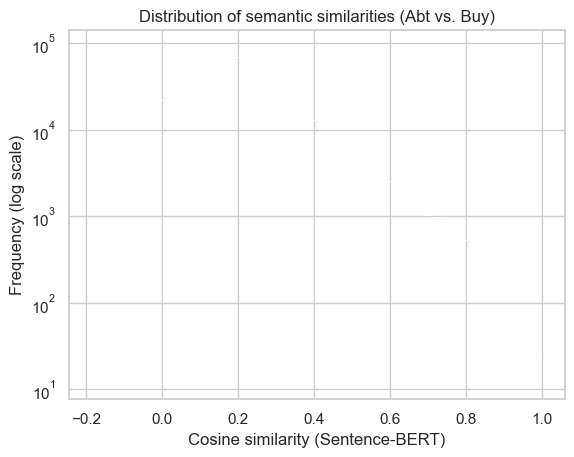

In [22]:
# ===============================================
# Representação semântica com Sentence-BERT
# ===============================================

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Carrega o modelo pré-treinado (pode usar outros, ex: 'all-mpnet-base-v2')
model_name = 'all-MiniLM-L6-v2'
sbert = SentenceTransformer(model_name)

# Extrai nomes dos produtos
names_A = tableA['name'].fillna('').tolist()
names_B = tableB['name'].fillna('').tolist()

# Gera embeddings semânticos (dimensão ~384)
emb_A = sbert.encode(names_A, convert_to_numpy=True, show_progress_bar=True)
emb_B = sbert.encode(names_B, convert_to_numpy=True, show_progress_bar=True)


## 5️⃣ Visualização de Similaridades com t-SNE

O código abaixo utiliza o método **t-SNE** (*t-Distributed Stochastic Neighbor Embedding*) para projetar os vetores TF-IDF dos nomes de produtos das duas lojas (Abt e Buy) em um **espaço bidimensional**, permitindo uma visualização intuitiva de como os produtos se distribuem semanticamente.

/Users/ebezerra/miniconda3/envs/cic1205/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


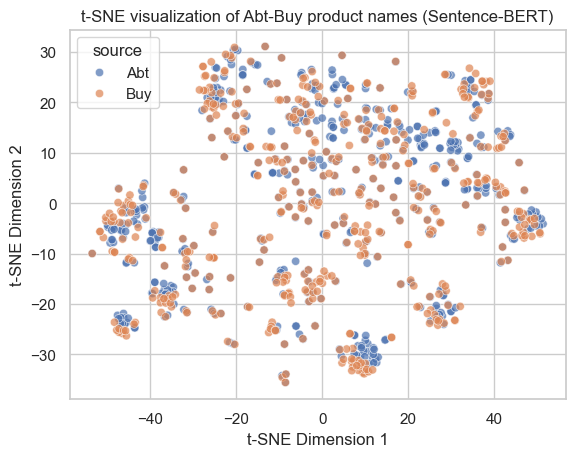

In [23]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Concatena 500 embeddings de cada loja
X = np.vstack([emb_A[:500], emb_B[:500]])
labels = ['Abt'] * 500 + ['Buy'] * 500

# Redução de dimensionalidade com t-SNE (versões recentes do scikit-learn)
tsne = TSNE(n_components=2, perplexity=40, random_state=42, max_iter=1000)
X_emb = tsne.fit_transform(X)

# Criação do DataFrame para visualização
df_tsne = pd.DataFrame({
    'x': X_emb[:, 0],
    'y': X_emb[:, 1],
    'source': labels
})

# Plot do gráfico
sns.set(style="whitegrid")
sns.scatterplot(data=df_tsne, x='x', y='y', hue='source', alpha=0.7)
plt.title('t-SNE visualization of Abt-Buy product names (Sentence-BERT)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()



## (5) Visualização de Similaridades com t-SNE

In [24]:
train['label'].value_counts(normalize=True)

label
0    0.892739
1    0.107261
Name: proportion, dtype: float64

# Parte 2: Treinamento e avaliação (Siamese Neural Network)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


Essa parte faz o mapeamento entre os IDs dos produtos e os vetores numéricos usados pelo modelo.

In [26]:
# ============================================================
# Mapeamento de vetores SBERT para IDs de produtos (Abt e Buy)
# ============================================================

# emb_A e emb_B já foram gerados anteriormente pelo SentenceTransformer
# e têm tipo numpy.ndarray de forma (n_registros, dimensão_do_embedding)

A_vectors = emb_A          # já é denso
B_vectors = emb_B          # já é denso

# Cria dicionários para mapear o id → índice do vetor correspondente
id_to_idx_A = {rid: i for i, rid in enumerate(tableA['id'])}
id_to_idx_B = {rid: i for i, rid in enumerate(tableB['id'])}

# Função que retorna os embeddings correspondentes ao par de produtos
def get_pair_vector(row):
    vecA = A_vectors[id_to_idx_A[row['ltable_id']]]
    vecB = B_vectors[id_to_idx_B[row['rtable_id']]]
    return vecA, vecB


In [27]:
from torch.utils.data import Dataset
import torch
import numpy as np

class PairDataset(Dataset):
    def __init__(self, df, A_vectors, B_vectors, id_to_idx_A, id_to_idx_B):
        self.df = df.reset_index(drop=True)
        self.A_vectors = A_vectors
        self.B_vectors = B_vectors
        self.id_to_idx_A = id_to_idx_A
        self.id_to_idx_B = id_to_idx_B

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Recupera embeddings SBERT correspondentes
        xA = self.A_vectors[self.id_to_idx_A[row["ltable_id"]]]
        xB = self.B_vectors[self.id_to_idx_B[row["rtable_id"]]]
        # Converte para tensores PyTorch
        xA = torch.tensor(xA, dtype=torch.float32)
        xB = torch.tensor(xB, dtype=torch.float32)
        y = torch.tensor(row["label"], dtype=torch.float32)
        return xA, xB, y

pos_weight = 8.32


/Users/ebezerra/miniconda3/envs/cic1205/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001/300 | Train Loss: 1.7975 | Valid Loss: 2.0122 | Valid F1: 0.1942
Epoch 002/300 | Train Loss: 1.2062 | Valid Loss: 2.0654 | Valid F1: 0.1946
Epoch 003/300 | Train Loss: 1.1254 | Valid Loss: 1.9738 | Valid F1: 0.1980
Epoch 004/300 | Train Loss: 1.0599 | Valid Loss: 1.8669 | Valid F1: 0.2036
Epoch 005/300 | Train Loss: 1.0215 | Valid Loss: 1.8064 | Valid F1: 0.2069
Epoch 006/300 | Train Loss: 0.9512 | Valid Loss: 1.7202 | Valid F1: 0.2202
Epoch 007/300 | Train Loss: 0.8713 | Valid Loss: 1.7222 | Valid F1: 0.2246
Epoch 008/300 | Train Loss: 0.8273 | Valid Loss: 1.6309 | Valid F1: 0.2440
Epoch 009/300 | Train Loss: 0.7135 | Valid Loss: 1.5885 | Valid F1: 0.2502
Epoch 010/300 | Train Loss: 0.6508 | Valid Loss: 1.4554 | Valid F1: 0.2745
Epoch 011/300 | Train Loss: 0.5825 | Valid Loss: 1.5043 | Valid F1: 0.2906
Epoch 012/300 | Train Loss: 0.5098 | Valid Loss: 1.4841 | Valid F1: 0.2874
Epoch 013/300 | Train Loss: 0.4523 | Valid Loss: 1.3946 | Valid F1: 0.3035
Epoch 014/300 | Train Los

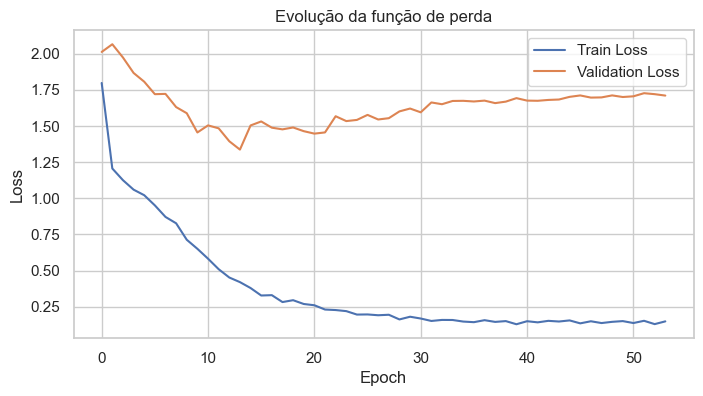

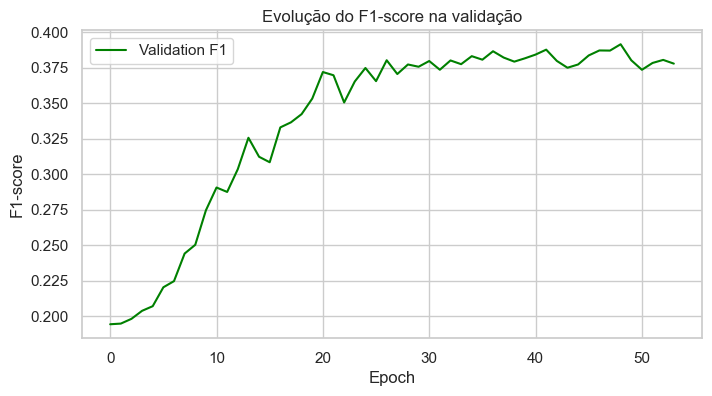

In [28]:
# ============================================================
# Treinamento otimizado do modelo siamês (versão aprimorada)
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# 1️⃣ Modelo Siamese otimizado
# ------------------------------
class SiameseMLP(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=256, dropout_rate=0.1, residual=True):
        super().__init__()
        self.residual = residual

        # Encoder mais largo
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Classificador com opção de conexão residual
        self.linear1 = nn.Linear(hidden_dim // 2, hidden_dim // 2)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, xA, xB):
        # Normaliza embeddings e computa diferença
        xA = nn.functional.normalize(xA, p=2, dim=1)
        xB = nn.functional.normalize(xB, p=2, dim=1)
        eA = self.encoder(xA)
        eB = self.encoder(xB)
        diff = torch.abs(eA - eB)

        # Bloco residual
        if self.residual:
            h = self.relu(self.linear1(diff))
            out = self.linear2(h + diff)
        else:
            h = self.relu(self.linear1(diff))
            out = self.linear2(h)

        return out.squeeze()  # logits


# ------------------------------
# 2️⃣ Inicialização
# ------------------------------
model = SiameseMLP(input_dim=A_vectors.shape[1], hidden_dim=256, dropout_rate=0.1, residual=True).to(device)

# Ponderação positiva
n_pos = len(train[train.label == 1])
n_neg = len(train[train.label == 0])
pos_weight = torch.tensor([n_neg / n_pos]).to(device)
print(f"pos_weight = {pos_weight.item():.2f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Scheduler para reduzir lr quando a validação estagnar
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# ------------------------------
# 3️⃣ DataLoaders com amostragem reforçada para positivos
# ------------------------------
class_weights = train['label'].value_counts()
weights = train['label'].map({0: 1/class_weights[0], 1: 2/class_weights[1]}).values  # reforça positivos
sampler = WeightedRandomSampler(weights, len(weights))

train_ds = PairDataset(train, A_vectors, B_vectors, id_to_idx_A, id_to_idx_B)
valid_ds = PairDataset(valid, A_vectors, B_vectors, id_to_idx_A, id_to_idx_B)

train_dl = DataLoader(train_ds, batch_size=128, sampler=sampler)
valid_dl = DataLoader(valid_ds, batch_size=256)

# ------------------------------
# 4️⃣ Funções auxiliares
# ------------------------------
def evaluate_loss(dl):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xa, xb, y in dl:
            xa, xb, y = xa.to(device), xb.to(device), y.to(device)
            logits = model(xa, xb)
            loss = criterion(logits, y)
            total_loss += loss.item()
    return total_loss / len(dl)

def evaluate_f1(dl, threshold=0.5):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xa, xb, y in dl:
            xa, xb, y = xa.to(device), xb.to(device), y.to(device)
            logits = model(xa, xb)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).long().cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds)
    return f1_score(y_true, y_pred, zero_division=0)

# ------------------------------
# 5️⃣ Loop de treinamento
# ------------------------------
num_epochs = 300
patience = 40
best_val_loss = float('inf')
wait = 0
history = {'train_loss': [], 'valid_loss': [], 'valid_f1': []}

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for xa, xb, y in train_dl:
        xa, xb, y = xa.to(device), xb.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(xa, xb)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dl)
    avg_valid_loss = evaluate_loss(valid_dl)
    f1_val = evaluate_f1(valid_dl)
    scheduler.step(avg_valid_loss)

    history['train_loss'].append(avg_train_loss)
    history['valid_loss'].append(avg_valid_loss)
    history['valid_f1'].append(f1_val)

    print(f"Epoch {epoch+1:03d}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Valid Loss: {avg_valid_loss:.4f} | "
          f"Valid F1: {f1_val:.4f}")

    # Early stopping
    if avg_valid_loss < best_val_loss:
        best_val_loss = avg_valid_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# ------------------------------
# 6️⃣ Curvas de perda e F1-score
# ------------------------------
plt.figure(figsize=(8,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Evolução da função de perda')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history['valid_f1'], label='Validation F1', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.title('Evolução do F1-score na validação')
plt.show()


✅ Best threshold (by F1 on validation): 0.357 | F1 = 0.3808

===== Final Test Evaluation (using calibrated threshold) =====
Precision: 0.2801
Recall:    0.7330
F1-score:  0.4054
ROC-AUC:   0.8104


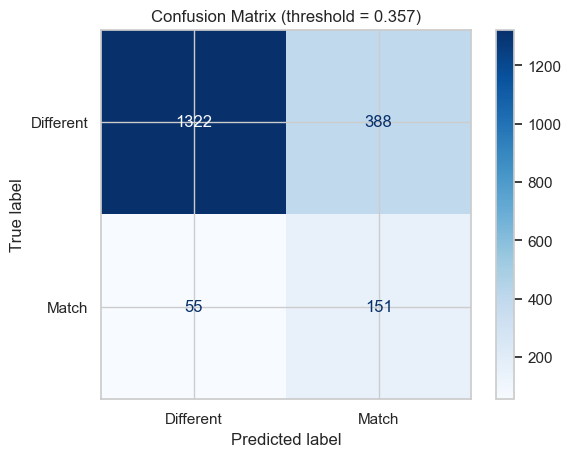

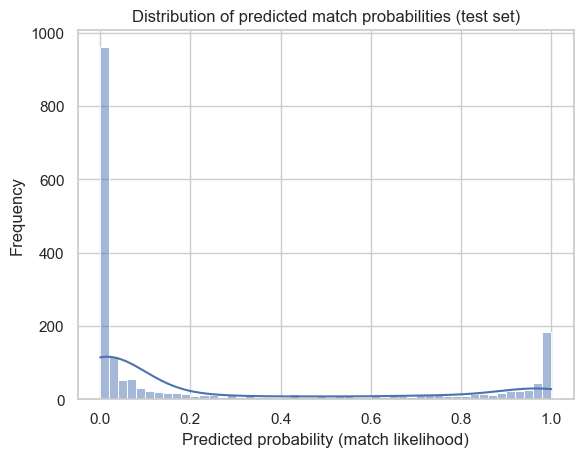


✅ Resultados salvos em 'results_test.csv' (1916 linhas)
 ltable_id  rtable_id                                                                       name_A                                            name_B  probability  pred_label  true_label
       445        910                   sony pink cyber-shot 7.2 megapixel digital camera dscw120p         olympus fe-360 digital camera pink 226540     0.815853           1         0.0
       477        910                                sony silver cyber-shot digital camera dscw150         olympus fe-360 digital camera pink 226540     0.015563           0         0.0
       445        415                   sony pink cyber-shot 7.2 megapixel digital camera dscw120p    sony lcs-twa/b cyber-shot camera case lcstwa/b     0.003604           0         0.0
       483        415                                  sony red cyber-shot digital camera dscw170r    sony lcs-twa/b cyber-shot camera case lcstwa/b     0.000143           0         0.0
       241   

In [29]:
# ==========================================================
# Avaliação e calibração com probabilidades sigmoid
# ==========================================================

from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ----------------------------------------------------------
# 1️⃣ Calibração do threshold no conjunto de validação
# ----------------------------------------------------------
valid_ds = PairDataset(valid, A_vectors, B_vectors, id_to_idx_A, id_to_idx_B)
valid_dl = DataLoader(valid_ds, batch_size=256)

model.eval()
y_val_true, y_val_prob = [], []

with torch.no_grad():
    for xa, xb, y in valid_dl:
        xa, xb, y = xa.to(device), xb.to(device), y.to(device)
        logits = model(xa, xb)
        probs = torch.sigmoid(logits)  # converte logits → probabilidades [0,1]
        y_val_true.extend(y.cpu().numpy())
        y_val_prob.extend(probs.cpu().numpy())

y_val_true = np.array(y_val_true)
y_val_prob = np.array(y_val_prob)

# Encontra o melhor threshold com base no F1-score
precisions, recalls, thresholds = precision_recall_curve(y_val_true, y_val_prob)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_thresh = thresholds[np.nanargmax(f1s)]
best_f1 = np.nanmax(f1s)

print(f"✅ Best threshold (by F1 on validation): {best_thresh:.3f} | F1 = {best_f1:.4f}")

# ----------------------------------------------------------
# 2️⃣ Avaliação final no conjunto de teste
# ----------------------------------------------------------
test_ds = PairDataset(test, A_vectors, B_vectors, id_to_idx_A, id_to_idx_B)
test_dl = DataLoader(test_ds, batch_size=256)

y_true, y_prob = [], []

with torch.no_grad():
    for xa, xb, y in test_dl:
        xa, xb, y = xa.to(device), xb.to(device), y.to(device)
        logits = model(xa, xb)
        probs = torch.sigmoid(logits)  # converte logits → probabilidades
        y_true.extend(y.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= best_thresh).astype(int)

# ----------------------------------------------------------
# 3️⃣ Métricas finais
# ----------------------------------------------------------
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)
roc_auc   = roc_auc_score(y_true, y_prob)

print("\n===== Final Test Evaluation (using calibrated threshold) =====")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# ----------------------------------------------------------
# 4️⃣ Visualizações
# ----------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Different", "Match"]).plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {best_thresh:.3f})")
plt.show()

sns.histplot(y_prob, bins=50, kde=True)
plt.title('Distribution of predicted match probabilities (test set)')
plt.xlabel('Predicted probability (match likelihood)')
plt.ylabel('Frequency')
plt.show()

# ----------------------------------------------------------
# 5️⃣ Exporta resultados detalhados
# ----------------------------------------------------------
results_df = test.copy()
results_df['probability'] = y_prob
results_df['pred_label'] = y_pred
results_df['true_label'] = y_true

results_df = (
    results_df.merge(tableA[['id', 'name']], left_on='ltable_id', right_on='id')
               .merge(tableB[['id', 'name']], left_on='rtable_id', right_on='id', suffixes=('_A', '_B'))
               [['ltable_id', 'rtable_id', 'name_A', 'name_B',
                 'probability', 'pred_label', 'true_label']]
)

results_df.to_csv('results_test.csv', index=False)
print(f"\n✅ Resultados salvos em 'results_test.csv' ({len(results_df)} linhas)")
print(results_df.head(10).to_string(index=False))
